<a href="https://colab.research.google.com/github/ChabiMax/author_network/blob/main/Code/Question%202.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><center><strong><font color="chillipepper">Réseau Wikipédia des auteurs francophones</font></strong></center></h1>
<h5><center><font color="green">Science des réseaux sociaux et économiques <h3><center>


<center>
Maxime Chabriel, Yasmine Houri, Mathis Sansu  

ENSAE 2022
</center>

<h2><center><strong><font color="chillipepper">Analyses descriptives / Traitement de la problématique</font></strong></center></h2>

# Packages

In [1]:
!pip install python-louvain # Package de détection de communautés
from community import community_louvain # Algorithme de Louvain
import pandas as pd # Package pour travailler avec des dataframes
import networkx as nx # Package pour travailler avec des réseaux
#from networkx.algorithms import bipartite
import pickle as pkl # Package pour les objets python de type 'pickle'
from tqdm import tqdm_notebook # Package pour les barres de progression
import statsmodels.formula.api as smf # Package de modèles statistiques
import matplotlib.pyplot as plt # Package pour les visualisations graphiques
import numpy as np # Package de fonctions mathématiques
import seaborn as sns # Package pour les visualisations graphiques
from seaborn import matrix
from operator import itemgetter

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Données

## Import

In [2]:
git_url = "https://raw.githubusercontent.com/ChabiMax/author_network/main/" # Lien du repository GitHub pour récupérer les données
data = pd.read_pickle(git_url+'/Data/raw_data.pkl') # Import des données

## Visualisation

In [3]:
df = pd.DataFrame(data).T # Passage du dictionnaire sous forme de dataframe
df.head() # Visualisation des premières lignes

,name,link,date_mort,date_naissance,taille_html_article,network_interauteur,poids_liens_interauteur,genres_mentionnes,type,contemporain,poids_contempo_diff_naissance,poids_contempo_annees_communes,auteurs_du_genre,debut_genre,fin_genre
0,Turold,https://fr.wikipedia.org/wiki/Turold,NaN,NaN,73673,[],[],[],auteur,[],[],[],NaN,NaN,NaN
1,Philippe de Thaon,https://fr.wikipedia.org/wiki/Philippe_de_Thaon,NaN,NaN,68910,[],[],[],auteur,[],[],[],NaN,NaN,NaN
2,Benoît de Sainte-Maure,https://fr.wikipedia.org/wiki/Beno%C3%AEt_de_S...,NaN,NaN,83269,[4],[1],[1627],auteur,[],[],[],NaN,NaN,NaN
3,Jean Bodel,https://fr.wikipedia.org/wiki/Jean_Bodel,1165,NaN,73274,"[10, 22]","[1, 1]","[1663, 1691, 1604]",auteur,[],[],[],NaN,NaN,NaN
4,Wace,https://fr.wikipedia.org/wiki/Wace,1174,1100,99714,[6],[2],"[1591, 1662]",auteur,"[5, 6, 7, 9, 10, 11]","[10, 30, 50, 60, 60, 60]","[52, 44, 24, 14, 14, 14]",NaN,NaN,NaN


# Réseau interauteurs : hyperliens auteurs sur les pages auteurs

## Table d'adjacence

In [4]:
id = 0 # Initialisation
id_link = id  # Identifiant
link_table = dict() # Création du dictionnaire pour stocker les données

for source in tqdm_notebook(df.index) : # Boucle sur nos lignes de dataframe brut
  if df.iloc[id]['type'] == "auteur": # En conditionnant au fait que les lignes se réfèrent aux auteurs
    for i in range(len(df.iloc[id]['network_interauteur'])): # On boucle sur les auteurs en lien avec l'auteur 'source'
      target = df.iloc[id]['network_interauteur'][i] # Récupération de l'auteur 'target'
      link_table[id_link] = {'source' : source, 'target' : target} # Création du lein entre auteurs dans le dictionnaire
      weight = df.iloc[id]['poids_liens_interauteur'][i] # Récupération du poids du lien
      link_table[id_link]['weight'] = weight # Assignation du poids au lien dans le dictionnaire
      if target in df.iloc[id]['contemporain'] : # Condition pour voir si l'auteur 'target' est contemporain de 'source'
        index_contemp = df.iloc[id]['contemporain'].index(target) # Récupération de l'identifiant du 'target'
        contemporain = 1
        diff_naissance = df.iloc[id]['poids_contempo_diff_naissance'][index_contemp]
        annees_communes = df.iloc[id]['poids_contempo_annees_communes'][index_contemp]
      else:
        contemporain = 0
        diff_naissance = 0
        annees_communes = 0
      link_table[id_link]['contemporain'] = contemporain
      link_table[id_link]['diff_naissance'] = diff_naissance
      link_table[id_link]['annees_communes'] = annees_communes
      id_link +=1
    id += 1
edge_links = pd.DataFrame(link_table).T
edge_links.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


  0%|          | 0/1786 [00:00<?, ?it/s]

,source,target,weight,contemporain,diff_naissance,annees_communes
0,2,4,1,0,0,0
1,3,10,1,0,0,0
2,3,22,1,0,0,0
3,4,6,2,1,30,44
4,6,4,1,1,30,44


## Graph networkx


In [5]:
# Création du graph orienté
GraphAuthorLink = nx.from_pandas_edgelist(edge_links, 'source', 'target', edge_attr = True, create_using=nx.DiGraph())
# On rajoute les attributs aux noeuds
df_node = df[df["type"] == "auteur"]
df_node['Node'] = df_node.index
NodeData = df_node.set_index('Node').to_dict('index').items()
GraphAuthorLink.add_nodes_from(NodeData)
print(nx.info(GraphAuthorLink))

DiGraph with 1584 nodes and 13021 edges


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


# Réseau interauteurs : partage d'un genre en commun

## Table d'adjacence

In [6]:
df_genre = df[df['type'] == 'genre']

list_link = []
for genre in tqdm_notebook(df_genre.index) :
  auteur_du_genre = df_genre['auteurs_du_genre'][genre]
  if len(auteur_du_genre) > 1 :
    auteur_vu = []
    for auteur in auteur_du_genre :
      if auteur is not None : 
        for auteur_bis in auteur_du_genre :
          if (auteur != auteur_bis) & (auteur_bis not in auteur_vu) :
            list_link.append([auteur, auteur_bis])
        auteur_vu.append(auteur)

edge_genre = pd.DataFrame(data = list_link)
edge_genre.rename(columns={0: "source", 1: "target"}, inplace = True)
edge_genre['weight'] = 1
edge_genre = edge_genre.groupby(['source','target'])['weight'].agg('count').reset_index()
edge_genre['contemporain'] = 0
edge_genre['diff_naissance'] = 0
edge_genre['annees_communes'] = 0
edge_genre['taille_html_article'] = 0

for i in tqdm_notebook(edge_genre.index) :
  source = edge_genre.iloc[i]['source']
  target = edge_genre.iloc[i]['target']
  taille = df.iloc[source]['taille_html_article']
  if target in df.iloc[source]['contemporain'] :
    index_contemp = df.iloc[source]['contemporain'].index(target)
    contemporain = 1
    diff_naissance = df.iloc[source]['poids_contempo_diff_naissance'][index_contemp]
    annees_communes = df.iloc[source]['poids_contempo_annees_communes'][index_contemp]
  else :
    contemporain = 0
    diff_naissance = 0
    annees_communes = 0
  edge_genre['contemporain'][i] = contemporain
  edge_genre['diff_naissance'][i] = diff_naissance
  edge_genre['annees_communes'][i] = annees_communes
  edge_genre['taille_html_article'][i] = taille



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


  0%|          | 0/202 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/91863 [00:00<?, ?it/s]

## Graph networkx


In [7]:
# Création du graph non orienté
GraphGenreLink = nx.from_pandas_edgelist(edge_genre, 'source', 'target', edge_attr = True, create_using=nx.Graph())
# On rajoute les attributs aux noeuds
df_node = df[df["type"] == "auteur"]
df_node['Node'] = df_node.index
NodeData = df_node.set_index('Node').to_dict('index').items()
GraphGenreLink.add_nodes_from(NodeData)
print(nx.info(GraphGenreLink))

Graph with 1584 nodes and 91863 edges


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


# Contrôle de la taille des articles : création de coefficients de pondérations


Visualisation de la répartition des tailles d'articles (mise au log).

(array([  1.,   0.,   0.,   0.,   0.,   0.,   4.,  25.,  55., 102., 115.,
        138., 104., 140., 114., 115., 101.,  82.,  75.,  59.,  64.,  54.,
         47.,  25.,  35.,  24.,  17.,  24.,  17.,   7.,   8.,   1.,   7.,
          2.,   5.,  10.,   4.,   1.,   0.,   2.]),
 array([ 9.99729661, 10.09837902, 10.19946143, 10.30054384, 10.40162625,
        10.50270866, 10.60379107, 10.70487348, 10.80595589, 10.9070383 ,
        11.00812071, 11.10920312, 11.21028553, 11.31136794, 11.41245035,
        11.51353276, 11.61461518, 11.71569759, 11.81678   , 11.91786241,
        12.01894482, 12.12002723, 12.22110964, 12.32219205, 12.42327446,
        12.52435687, 12.62543928, 12.72652169, 12.8276041 , 12.92868651,
        13.02976892, 13.13085133, 13.23193374, 13.33301615, 13.43409857,
        13.53518098, 13.63626339, 13.7373458 , 13.83842821, 13.93951062,
        14.04059303]),
 <a list of 40 Patch objects>)

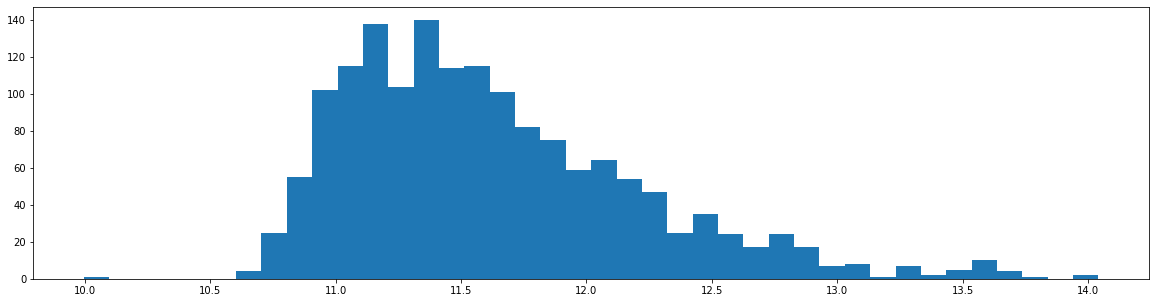

In [8]:
plt.rcParams['figure.figsize'] = [20, 5]
plt.hist(np.log(pd.to_numeric(df['taille_html_article'])), bins = 40)

## Réseau interauteurs via auteurs



### Visualisation

On visualise la relation entre la taille de l'article d'un auteur et son nombre de connexions (degré sortant). 

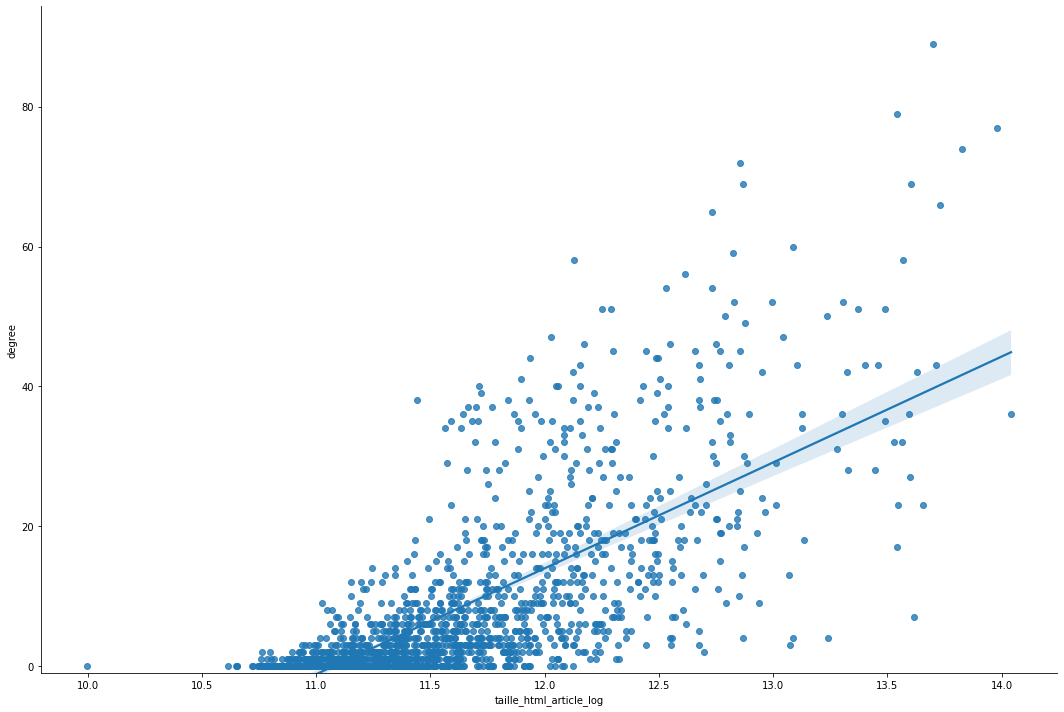

In [9]:
plt.rcParams['figure.figsize'] = [20, 5]

tailles = nx.get_node_attributes(GraphAuthorLink, 'taille_html_article')
tailles = pd.DataFrame(tailles.items())
degrees = dict()
for (node, val) in GraphAuthorLink.out_degree() :
  degrees[node] = val
degrees = pd.DataFrame(degrees.items())
degree_tailles_df = pd.merge(degrees, tailles, on=0, how='outer')
degree_tailles_df.columns = ['Id', 'degree', 'taille_html_article']
degree_tailles_df['taille_html_article_log'] = np.log(degree_tailles_df['taille_html_article'])
sns.lmplot(y = "degree", x = "taille_html_article_log", data = degree_tailles_df, height = 10, aspect = 15/10).set(ylim=(-1, None))

### Construction de la pondération

Un poids de la relation de l'auteur $i$ à l'auteur $j$ par la présence d'un hyperlien dans vers $j$ dans la page de $i$ était déjà fixé en fonction du nombre d'hyperliens vers $j$ que l'on trouvait dans la page de $i$ (notons ce poids $w_{i,j}$). Pour déterminer l'influence de la taille d'un article $i$ ($X_{i}$) sur son nombre de connexion ($Y_{i}$), on décide d'effectuer une régression linéaire :

$Y_{i} = \beta log(X_{i}) + ϵ_{i} ~~~~~ (1)~$

Notons bien que l'intercept est fixé à 0 (en effet, la relation $f$ entre la taille d'un article x et le nombre d'hypeliens qu'il inclut en son sein $f(x)$ ne fait aucun sens si l'on ne fixe pas $f(x) = 0$, c'est-à-dire simplement qu'un article de taille $0$ ne peut pas avoir d'hyperlien en son sein). Les résidus $ϵ$ de (1) (qu'on maximise à au minimum 0.1 pour éviter de faire disparaître certains liens) sont alors le nombre "réel" de relations (c'est à dire le nombre de relations retranché de l'effet artificiel de la taille de l'article) que l'auteur possède avec d'autres auteurs par les hyperliens présents sur sa page. Pour une discussion de ce choix de pondération, se référer à la partie "Discussion" du rapport.

Les poids $w_{i,j}$ sont donc actualisés en des poids $w'_{i,j}$ de façon à ce que leur somme fasse $ϵ_{i}$. On écrit :

$w'_{i,j} = w_{i,j}*\frac{max(ϵ_{i}, \: 0.1)}{\sum_{j}w_{i,j}} ~~~~   (2)$


In [10]:
model = smf.ols("degree ~ taille_html_article_log -1", data = degree_tailles_df)
model = model.fit()
coeff_reg = model.params['taille_html_article_log']
# intercept_reg = model.params['Intercept']

df['poids_liens_interauteur2'] = None
min_true_degrees = 0
for auteur in tqdm_notebook(df['name'][df['type'] == 'auteur']) :
  idx = int(df[df['name'] == auteur].index[0])
  poids = df[df['name'] == auteur]['poids_liens_interauteur']
  poids = list(poids)[0]
  if poids != [] :
    taille_article = df[df['name'] == auteur]['taille_html_article'].values[0]
    degree = len(df[df['name'] == auteur]['poids_liens_interauteur'].values[0])
    true_degree = degree - coeff_reg*np.log(taille_article)
    min_true_degrees = min(min_true_degrees, true_degree)

for auteur in tqdm_notebook(df['name'][df['type'] == 'auteur']) :
  idx = int(df[df['name'] == auteur].index[0])
  poids = df[df['name'] == auteur]['poids_liens_interauteur']
  poids = list(poids)[0]
  if poids != [] :
    true_degree = list(len(df[df['name'] == auteur]['poids_liens_interauteur'].values[0]) - coeff_reg*np.log(pd.to_numeric(df[df['name'] == auteur]['taille_html_article'])))[0]
    #normalisation_coeff = (true_degree - min_true_degrees + 0.1) / sum(poids)
    normalisation_coeff = max(true_degree, 0.1) / sum(poids)
    poids = [poid * normalisation_coeff for poid in poids]
  else :
    poids = []
  df.at[idx,'poids_liens_interauteur2'] = poids

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/1584 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/1584 [00:00<?, ?it/s]

Assignation des poids dans l'objet networkx

In [11]:
for node in GraphAuthorLink.nodes() :
  network = df['network_interauteur'][node]
  for i in range(0, len(network)) :
    indiv = network[i]
    GraphAuthorLink[node][indiv]['weight2'] = df['poids_liens_interauteur2'][node][i]

## Réseau interauteurs via genres


### Visualisation

On visualise la relation entre la taille de l'article d'un auteur et son nombre de connexions (degré). On note que la relation est beaucoup plus discontinue. Cela est dû au fait que certains genres regroupent énormément d'auteurs tels que "roman" ou "art poétique", et donc cette co-participation à un gros genre augmente mécaniquement le degré des auteurs y participant.

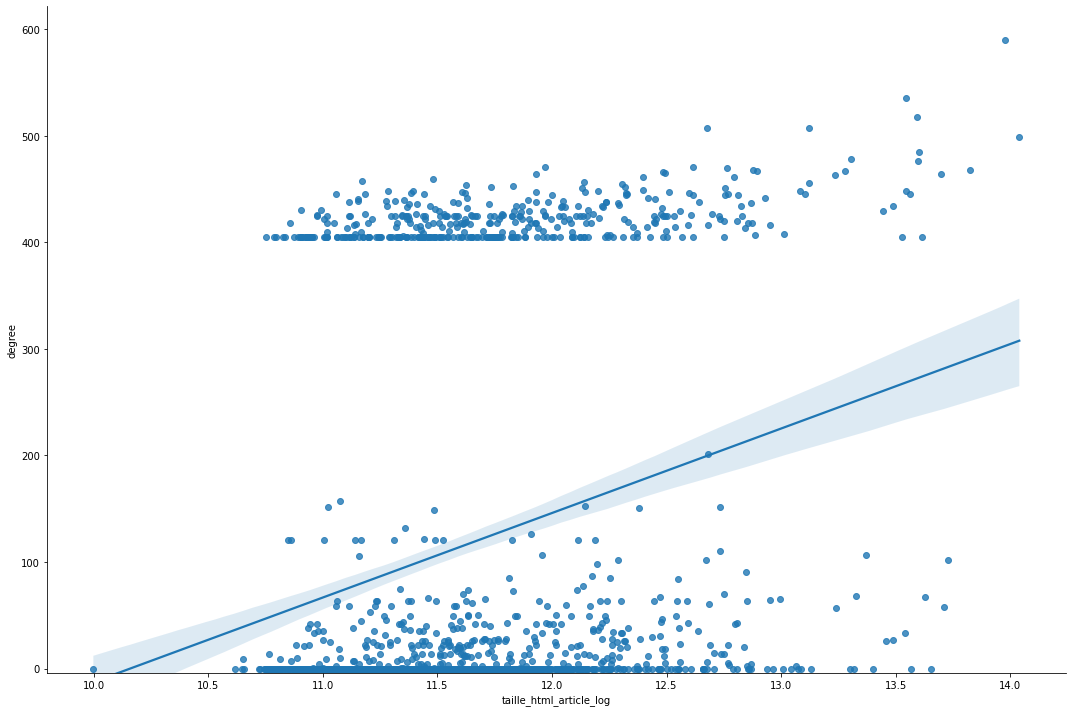

In [12]:
plt.rcParams['figure.figsize'] = [20, 5]

tailles_genre = nx.get_node_attributes(GraphGenreLink, 'taille_html_article')
tailles_genre = pd.DataFrame(tailles_genre.items())
degrees_genre = dict()
for (node, val) in GraphGenreLink.degree() :
  degrees_genre[node] = val
degrees_genre = pd.DataFrame(degrees_genre.items())
degree_genre_tailles_df = pd.merge(degrees_genre, tailles_genre, on=0, how='outer')
degree_genre_tailles_df.columns = ['Id', 'degree', 'taille_html_article']
degree_genre_tailles_df['taille_html_article_log'] = np.log(degree_genre_tailles_df['taille_html_article'])
sns.lmplot(y = "degree", x = "taille_html_article_log", data = degree_genre_tailles_df, height = 10, aspect = 15/10).set(ylim=(-4, None))

### Construction de la pondération

On construit la pondération de la même manière qu'explicité plus haut à une différence près : le réseau est non dirigé (les liens reposent sur la co-participation) et donc la pondération doit prendre en compte les attibuts de chaque noeud du lien, à avoir les tailles des deux articles d'auteurs ici. Pour ce faire, on calcule le coefficient de pondération pour chacun des nouds comme s'il produisait des liens dirigés. Chaque lien a donc deux coefficients de pondération qui lui sont rattachés selon la taille de l'article de chaque auteur du lien. Pour aassigner le poids au lien, on prend la moyenne de ces deux coefficients de pondération.

In [13]:
model = smf.ols("degree ~ taille_html_article_log -1", data = degree_genre_tailles_df)
model = model.fit()
coeff_reg = model.params['taille_html_article_log']

min_true_degrees = 0
for auteur in tqdm_notebook(degree_genre_tailles_df['Id']) :
  idx = int(degree_genre_tailles_df[degree_genre_tailles_df['Id'] == auteur].index[0])
  if degree_genre_tailles_df.at[idx,'degree'] != 0 :
    taille_article = degree_genre_tailles_df.at[idx,'taille_html_article']
    degree = degree_genre_tailles_df.at[idx,'degree']
    true_degree = degree - coeff_reg*np.log(taille_article)
    min_true_degrees = min(min_true_degrees, true_degree)

edge_genre['poids_liens_taille_article_source'] = edge_genre['weight']
edge_genre['poids_liens_taille_article_target'] = edge_genre['weight']
degree_genre_tailles_df['true_degree'] = 0.0
for auteur in tqdm_notebook(degree_genre_tailles_df['Id']) :
  idx = int(degree_genre_tailles_df[degree_genre_tailles_df['Id'] == auteur].index[0])
  if degree_genre_tailles_df.at[idx,'degree'] != 0 :
    degree = degree_genre_tailles_df.at[idx,'degree']
    taille_article = degree_genre_tailles_df.at[idx,'taille_html_article']
    true_degree = degree - coeff_reg*np.log(taille_article)
    degree_genre_tailles_df.at[idx, 'true_degree'] = true_degree
    sum_poids = edge_genre['weight'][edge_genre['source'] == auteur].sum() + edge_genre['weight'][edge_genre['target'] == auteur].sum()
    #normalisation_coeff = (true_degree - min_true_degrees + 0.1) / sum_poids
    normalisation_coeff = max(true_degree, 0.1) / sum_poids
    index = edge_genre[edge_genre['source'] == auteur].index
    if len(index) != 0 :
      edge_genre.loc[index, 'poids_liens_taille_article_source'] *= normalisation_coeff
    index = edge_genre[edge_genre['target'] == auteur].index
    if len(index) != 0 :
      edge_genre.loc[index, 'poids_liens_taille_article_target'] *= normalisation_coeff

edge_genre['weight2'] = edge_genre[['poids_liens_taille_article_source','poids_liens_taille_article_target']].mean(axis = 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/1584 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/1584 [00:00<?, ?it/s]

Assignation des poids à l'objet networkx

In [14]:
# Création du graph non orienté
GraphGenreLink = nx.from_pandas_edgelist(edge_genre, 'source', 'target', edge_attr = True, create_using=nx.Graph())
# On rajoute les attributs
df_node = df[df["type"] == "auteur"]
df_node['Node'] = df_node.index
NodeData = df_node.set_index('Node').to_dict('index').items()
GraphGenreLink.add_nodes_from(NodeData)
print(nx.info(GraphGenreLink)) 

Graph with 1584 nodes and 91863 edges


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


# Contrôle de l'éclatement des genres : création de coefficients de pondérations

Les genres sont problématiques car leur dénombrement est confronté à de nombreux biais. Notamment, certains genres sont imbriqués les uns dans les autres ('roman historique' est une sous-catégorie de 'roman' par exemple), ce qui les démultiplie artificiellement. Cependant on ne peut pas non plus les subsumer les uns dans les autres car on est confronté à la création de nouvelles interférences : quels genres subsumer, à quel niveau ? Tous les genres ne sont pas exactement imbriqués les uns dans les autres, et les recoupements se font dans un espace continu, comment prendre cette dimension en compte ? 

Notre projet avait ainsi défini le genre littéraire : un vision de l'écriture ou une manière d'écrire qui peut se définir par une communauté d'auteurs partageant cette vision ou empruntant des éléments du genre en question dans leur propre travail. Si un genre peut se définir par une communauté d'auteurs, on peut alors dire que la proximité entre deux genres peut se mesurer par le nombre d'auteurs communs à leurs communautés respectives. Pour un genre $i$, on peut définir un poids $w_{i}$ tel que : 

$w_{i} = \prod_{j} \frac{\#(auteur \: dans \: i \: ou \: j)}{\#(auteurs \: dans \: i) \:+\: \#(auteurs \: dans \: j)} ~~~~ (3)$

Plus un genre se distingue des autres genres en termes de communauté d'auteurs, plus son coefficient de pondération associé sera proche de 1.

In [15]:
df['poids_genre'] = None
df.loc[df['type'] == 'genre', 'poids_genre'] = 1

for genre in tqdm_notebook(np.unique(df[df['type'] == 'genre']['name'])) :
  for genre_bis in np.unique(df[df['type'] == 'genre']['name']) :
    if genre != genre_bis :
      auteurs_du_genre = df.loc[df['name'] == genre, 'auteurs_du_genre']
      auteurs_du_genre_bis = df.loc[df['name'] == genre_bis, 'auteurs_du_genre']
      liste = list(auteurs_du_genre)[0]
      liste_bis = list(auteurs_du_genre_bis)[0]
      if (len(liste) != 0) & (len(liste_bis) != 0) :
        coeff = len(np.unique(liste + liste_bis)) / (len(liste) + len(liste_bis))
        df.loc[df['name'] == genre, 'poids_genre'] = df.loc[df['name'] == genre, 'poids_genre']*((1+ coeff)/2)
        

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


  0%|          | 0/190 [00:00<?, ?it/s]

Pour le graph interauteurs via genres, il faut pouvoir traduire les poids des genres en poids des liens entre deux auteurs. Le poids du lien entre les nodes $i$ et $j$ est alors défini comme la somme des poids des genres qu'ils ont en commun. 

In [16]:
for source, target in tqdm_notebook(GraphGenreLink.edges()) :
  genres_source = df.iloc[source]['genres_mentionnes']
  genres_target = df.iloc[target]['genres_mentionnes']
  genres_communs = [genre for genre in genres_source if genre in genres_target]
  genres_communs_poids = [df.iloc[genre]['poids_genre'] for genre in genres_communs]
  weight = np.sum(genres_communs_poids)
  GraphGenreLink[source][target]['weight3'] = weight

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


  0%|          | 0/91863 [00:00<?, ?it/s]

Enfin, on concilie nos deux approches de pondération en créant un dernière pondération qui prend en compte les deux dimensions (biais de la taille des articles et biais de la catégorisation des genres) : on associe au lien entre deux auteurs pour le réseau interauteurs via genre le poids correpondant au produit des deux coefficients de pondération précédemment calculés.

In [17]:
  GraphGenreLink[source][target]['weight4'] = GraphGenreLink[source][target]['weight2'] * GraphGenreLink[source][target]['weight3']

# Statisiques descriptives du réseau 1 (interauteurs via auteurs)

Caractérisitique du graph des auteurs liés par les hyperliens sans isolats. 

In [18]:
# Removing isolates
GraphAuthorLink_withoutiso = GraphAuthorLink
GraphAuthorLink_withoutiso.remove_nodes_from(list(nx.isolates(GraphAuthorLink_withoutiso)))

print('Dirigé :')
print(type(GraphAuthorLink))
print('\nNombre de noeuds :')
print(GraphAuthorLink_withoutiso.number_of_nodes())
print('\nDensité :')
print(nx.density(GraphAuthorLink_withoutiso))
print('\nRéciprocité globale :')
print(nx.reciprocity(GraphAuthorLink_withoutiso))
print('\nTransitivité :')
print(nx.transitivity(GraphAuthorLink_withoutiso)) # Coeff de cluster global
print('\nAverage clustering :')
print(nx.average_clustering(GraphAuthorLink_withoutiso)) 
print('\nNombre de cliques :')
print(len(list(nx.find_cliques(GraphAuthorLink_withoutiso.to_undirected()))))
print('\nLe graph est connecté :')
print(nx.is_connected(GraphAuthorLink_withoutiso.to_undirected()))
print('\nLe graph est faiblement connecté :')
print(nx.is_weakly_connected(GraphAuthorLink_withoutiso))

Dirigé :
<class 'networkx.classes.digraph.DiGraph'>

Nombre de noeuds :
1250

Densité :
0.008340112089671737

Réciprocité globale :
0.5131710314107979

Transitivité :
0.3258701289432364

Average clustering :
0.201685607790658

Nombre de cliques :
6421

Le graph est connecté :
False

Le graph est faiblement connecté :
False


# Statisiques descriptives du réseau 2 (interauteurs via genres)

Caractérisitique du graph des auteurs liés par les genres sans isolats. 

In [19]:
# Removing isolates
GraphGenreLink_withoutiso = GraphGenreLink.copy()
GraphGenreLink_withoutiso.remove_nodes_from(list(nx.isolates(GraphGenreLink_withoutiso)))

print('Non dirigé :')
print(type(GraphGenreLink))
print('\nNombre de noeuds :')
print(GraphGenreLink.number_of_nodes())
print('\nNombre de noeuds non isolés :')
print(GraphGenreLink_withoutiso.number_of_nodes())
print('\nDensité :')
#print(nx.density(GraphGenreLink_withoutiso)) # Pas de réciprocité, le graph est non dirigé
#print('\nRéciprocité globale :')
print(nx.reciprocity(GraphGenreLink_withoutiso))
print('\nTransitivité :')
print(nx.transitivity(GraphGenreLink_withoutiso)) # Coeff de cluster global
print('\nAverage clustering :')
print(nx.average_clustering(GraphGenreLink_withoutiso)) 
print('\nNombre de cliques :')
print(len(list(nx.find_cliques(GraphGenreLink_withoutiso))))
print('\nLe graph est connecté :')
print(nx.is_connected(GraphGenreLink))


Non dirigé :
<class 'networkx.classes.graph.Graph'>

Nombre de noeuds :
1584

Nombre de noeuds non isolés :
731

Densité :
0.0

Transitivité :
0.9280802707512089

Average clustering :
0.9037918887809653

Nombre de cliques :
592

Le graph est connecté :
False


# Question 1 : Les structures des réseaux 1 et 2 sont-elles comparables ? 

On établit des métriques qui servent à comparer les deux réseaux. 


## Comparaison des noeuds les plus importants de chacun des réseaux

In [28]:
matrix_data_importance = np.zeros((100,100))

for importance_noeud_genre in tqdm_notebook(range(1, 100)) :

  for importance_noeud_hyperlink in range(1, 100) :

    central_AuthorLink = dict(sorted(nx.degree_centrality(GraphAuthorLink).items(), key = itemgetter(1), reverse = True)[:importance_noeud_hyperlink])
    central_GenreLink = dict(sorted(nx.degree_centrality(GraphGenreLink).items(), key = itemgetter(1), reverse = True)[:importance_noeud_genre])

    common_central_nodes = central_AuthorLink.keys() & central_GenreLink.keys()
    ratio_genre_dans_hyperlink = len(common_central_nodes) / importance_noeud_hyperlink

    matrix_data_importance[importance_noeud_genre][importance_noeud_hyperlink] = ratio_genre_dans_hyperlink

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


  0%|          | 0/99 [00:00<?, ?it/s]

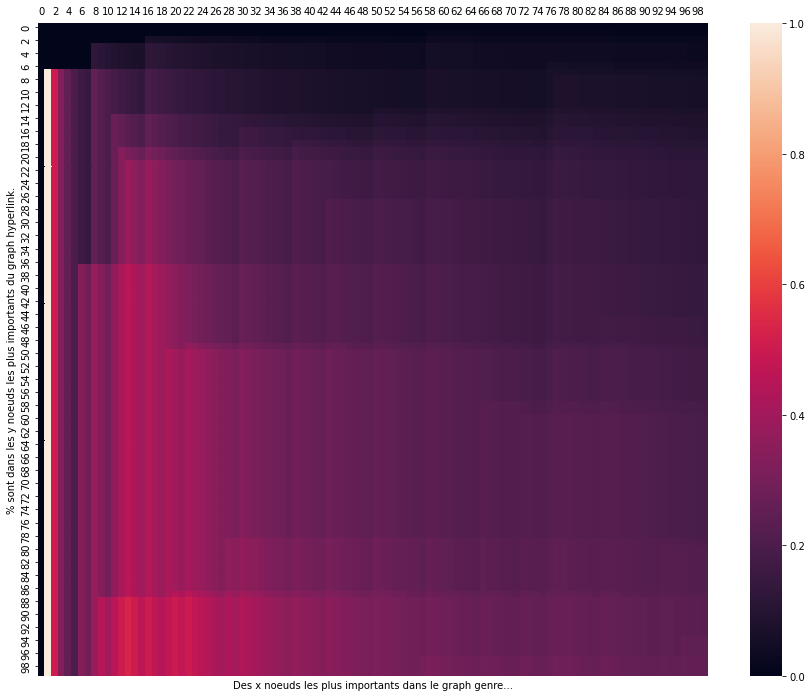

In [29]:
plt.rcParams['figure.figsize'] = [15, 12]

heatmap_data_importance = pd.DataFrame(matrix_data_importance)
# heatmap_data_importance = heatmap_data_importance.reindex(index = heatmap_data_importance.index[::-1])

sns.heatmap(heatmap_data_importance)
plt.xlabel("Des x noeuds les plus importants dans le graph genre...")
plt.ylabel("% sont dans les y noeuds les plus importants du graph hyperlink.")
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True)

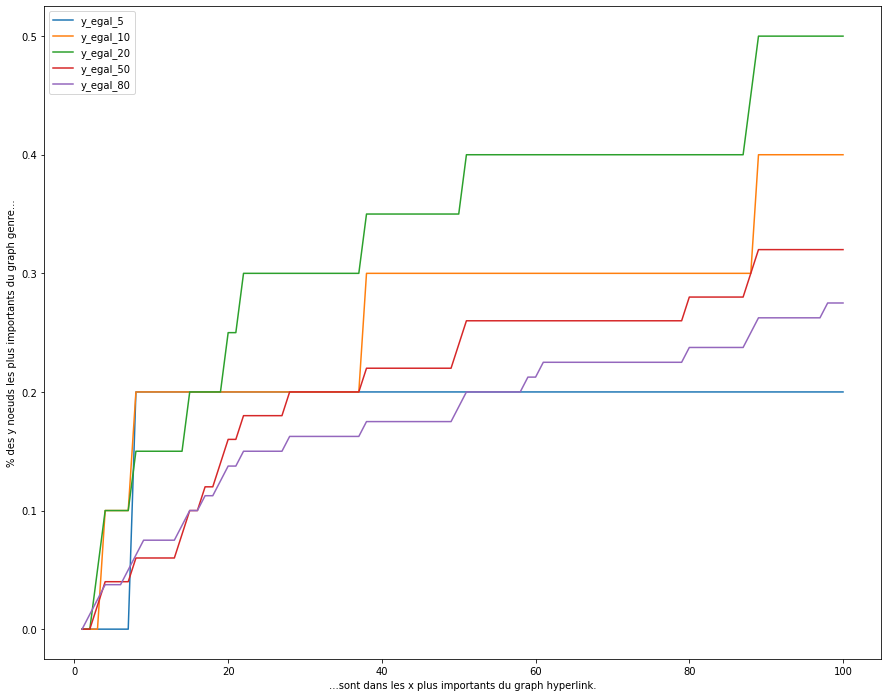

In [30]:
y_egal_5 = heatmap_data_importance[5]
y_egal_10 = heatmap_data_importance[10]
y_egal_20 = heatmap_data_importance[20]
y_egal_50 = heatmap_data_importance[50]
y_egal_80 = heatmap_data_importance[80]
x_axis = heatmap_data_importance.columns + 1

plt.plot(x_axis, y_egal_5, label = 'y_egal_5')
plt.plot(x_axis, y_egal_10, label = 'y_egal_10')
plt.plot(x_axis, y_egal_20, label = 'y_egal_20')
plt.plot(x_axis, y_egal_50, label = 'y_egal_50')
plt.plot( x_axis, y_egal_80, label = 'y_egal_80')
plt.ylabel("% des y noeuds les plus importants du graph genre...")
plt.xlabel("...sont dans les x plus importants du graph hyperlink.")
plt.legend()
plt.show()

## Comparaison de la distribution des degrés d'un réseau à l'autre

In [31]:
degrees_auteur = dict(GraphAuthorLink.out_degree(weight = 'weight2'))
degrees_genre = dict(GraphGenreLink.degree(weight = 'weight4'))

degree_df = pd.merge(pd.DataFrame(degrees_auteur, index = ['Degree auteur']).T, pd.DataFrame(degrees_genre, index = ['Degree genre']).T, left_index = True, right_index = True)

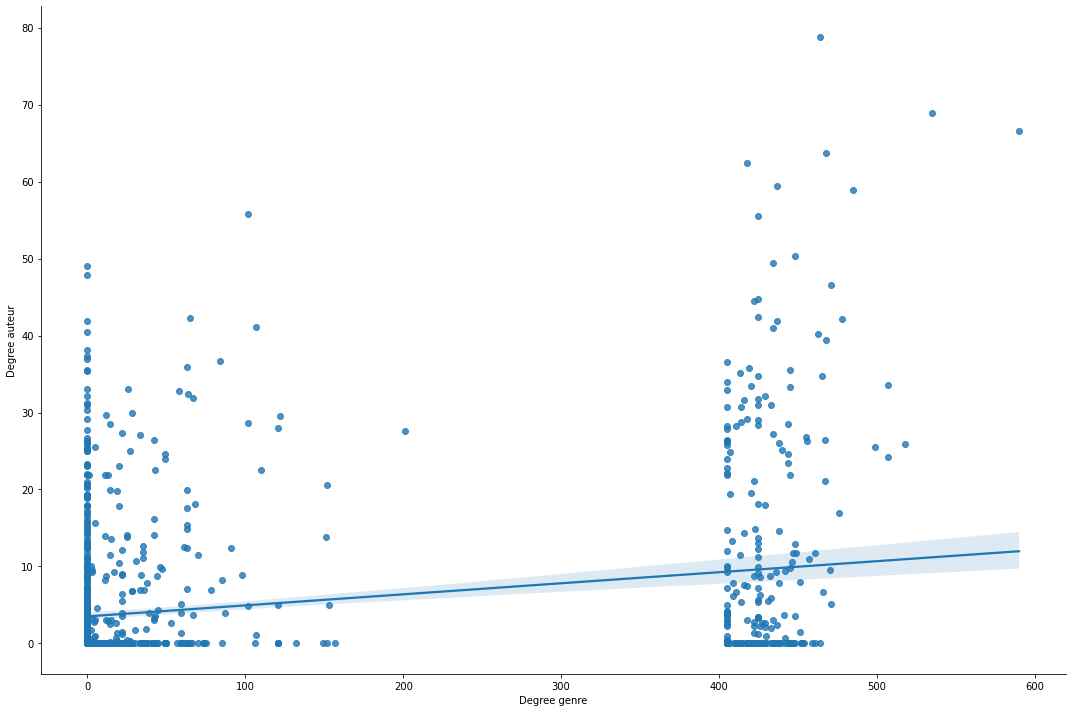

In [32]:
sns.lmplot(y = "Degree auteur", x = "Degree genre", data = degree_df, height = 10, aspect = 15/10)

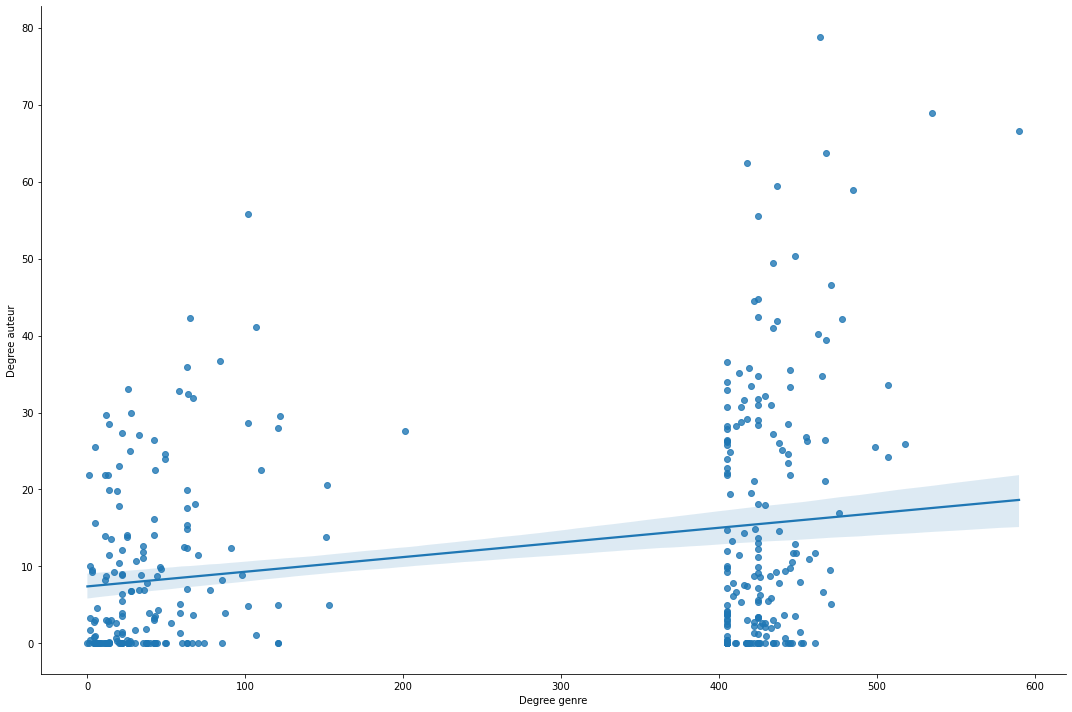

In [33]:
BOOL = (degree_df['Degree auteur'] != 0.1) & (degree_df['Degree genre'] != 0)
sns.lmplot(y = "Degree auteur", x = "Degree genre", data = degree_df[BOOL], height = 10, aspect = 15/10)

S'il semble y avoir un lien positif entre certaines caractéristiques des deux réseaux, ce lien ne permet de conclure à une franche similarité de ces derniers.

# Question 2 : Est-ce que une structure du réseau d'auteur permet d'expliquer l'émergence des genres ? 


On utilise dans la suite le réseau 1 (réseau interauteurs via auteurs) pour rendre compte des phénomènes d'émergence de genre. Le but est d'évaluer si les connexions entre individus (sur Wikipédia) recréent des mouvements collectifs : il est donc logique de s'appuyer sur ce réseau (et non le réseau 2 qui est construit par l'appartenence au genre).

## Analyse sans les poids

A simple titre de comparaison, nous commençons à effectuer nos analyses sans les poids. On commence par visualiser notre variable dépendente : le nombre de nouveaux genres littéraires apparaissant à une date donnée. 

(array([ 3.,  1.,  0.,  6.,  0.,  5.,  0.,  0.,  1.,  4.,  3.,  1.,  0.,
         2.,  4.,  1.,  0.,  8.,  9.,  5.,  2.,  3., 15.,  6.,  5.,  0.,
         1.,  3.,  2.,  1.,  0.,  1.,  3.,  1.,  1.,  5.,  7.,  4.,  2.,
        12.]),
 array([1100.0, 1121.825, 1143.65, 1165.475, 1187.3, 1209.125, 1230.95,
        1252.775, 1274.6, 1296.425, 1318.25, 1340.075, 1361.9, 1383.725,
        1405.55, 1427.375, 1449.2, 1471.025, 1492.85, 1514.675, 1536.5,
        1558.325, 1580.15, 1601.975, 1623.8, 1645.625, 1667.4499999999998,
        1689.275, 1711.1, 1732.925, 1754.75, 1776.5749999999998, 1798.4,
        1820.225, 1842.05, 1863.875, 1885.6999999999998, 1907.525, 1929.35,
        1951.175, 1973.0], dtype=object),
 <a list of 40 Patch objects>)

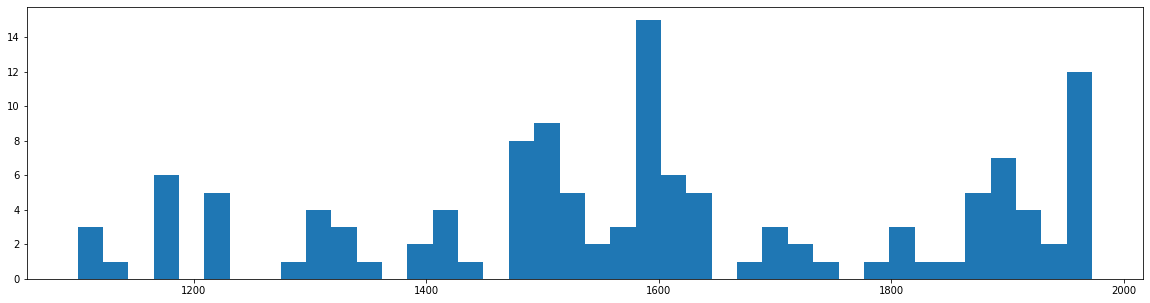

In [34]:
plt.rcParams['figure.figsize'] = [20, 5]

df_genre = df[df['type'] == 'genre']
df_genre = df_genre[df_genre['debut_genre'] != 9999]

plt.hist(df_genre['debut_genre'], bins = 40)

### Métriques

On produit des métriques pour chaque sous-graphe par année pour tester visuellement s'il existe une relation potentielle entre les structures du réseau et l'apparition d'un nouveau genre.

In [35]:
# Year subsets and building metrics
df_auteurs = df[df['type'] == 'auteur']
measure_list = {}
for année in tqdm_notebook(reversed(range(1000, 2025, 5))) :
  selected_nodes = [node for node, value in GraphAuthorLink.nodes(data=True) if (value['date_mort'] >= année) & (value['date_naissance'] <= année)] 
  subgraph = GraphAuthorLink.subgraph(selected_nodes)
  # if len(selected_nodes) > 10 :
  if len(selected_nodes) > 1 :
    try :
      subgraph_undirected = subgraph.to_undirected()
      subgraph_undirected_connected_components = sorted(nx.connected_components(subgraph_undirected), key=len, reverse=True)
      subgraph_undirected_giant = subgraph_undirected.subgraph(subgraph_undirected_connected_components[0])
      community = community_louvain.best_partition(subgraph_undirected, randomize = False)
      community_giant = community_louvain.best_partition(subgraph_undirected_giant, randomize = False)
      measure_list[année] = {'graph_size' : subgraph.number_of_nodes(),
                             'graph_giant_size' : subgraph_undirected_giant.number_of_nodes(),
                             'density_undirected' : nx.density(subgraph_undirected),
                             'density_directed' : nx.density(subgraph), 
                             'density_giant' : nx.density(subgraph_undirected_giant),
                             'average_clustering' : nx.average_clustering(subgraph_undirected_giant),
                             'transitivity' : nx.transitivity(subgraph),
                             'community' : max(list(community)),
                             'community_giant' : max(list(community_giant.values())),
                             'community_giant_variance' : np.var(list(community_giant.values())),
                             'modularity' : community_louvain.modularity(community_giant, subgraph_undirected_giant)}
    except : 
      pass

annee_data = pd.DataFrame(measure_list).T
annee_data['annee'] = annee_data.index

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


0it [00:00, ?it/s]

Taille du réseau et de sa composante géante

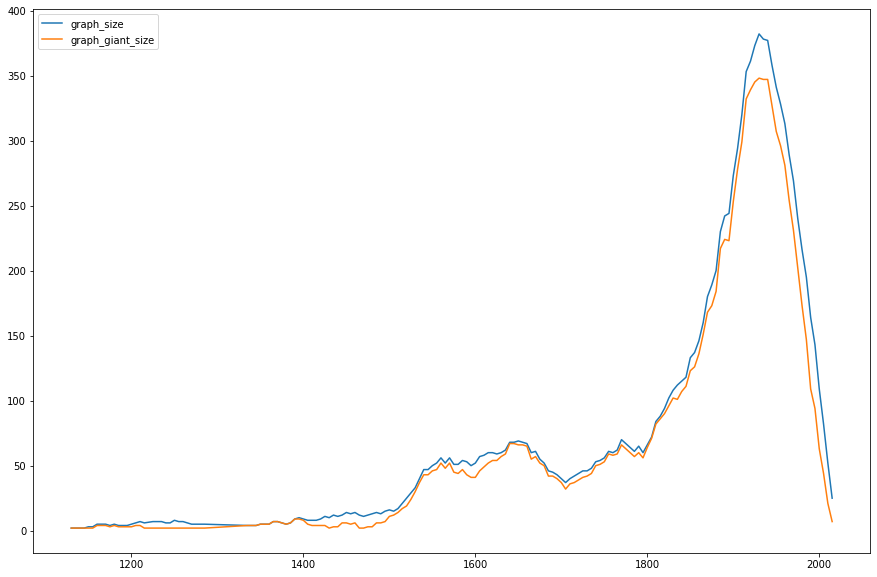

In [36]:
plt.rcParams['figure.figsize'] = [15, 10]

plt.plot(annee_data['annee'], annee_data['graph_size'], label = 'graph_size')
plt.plot(annee_data['annee'], annee_data['graph_giant_size'], label = 'graph_giant_size')
plt.legend()
plt.show()

Mesures de densité


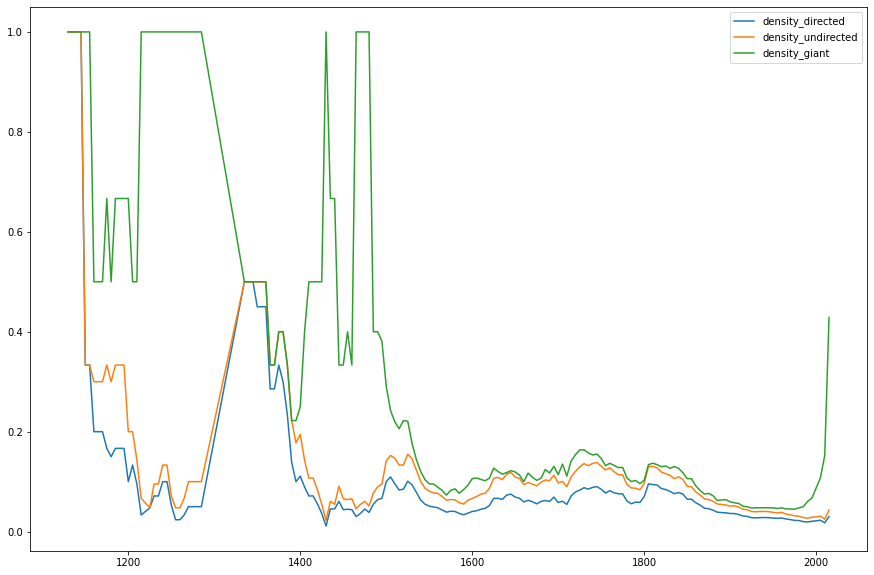

In [37]:
plt.rcParams['figure.figsize'] = [15, 10]

plt.plot(annee_data['annee'], annee_data['density_directed'], label = 'density_directed')
plt.plot(annee_data['annee'], annee_data['density_undirected'], label = 'density_undirected')
plt.plot(annee_data['annee'], annee_data['density_giant'], label = 'density_giant')
plt.legend()
plt.show()

Mesure de transitivité

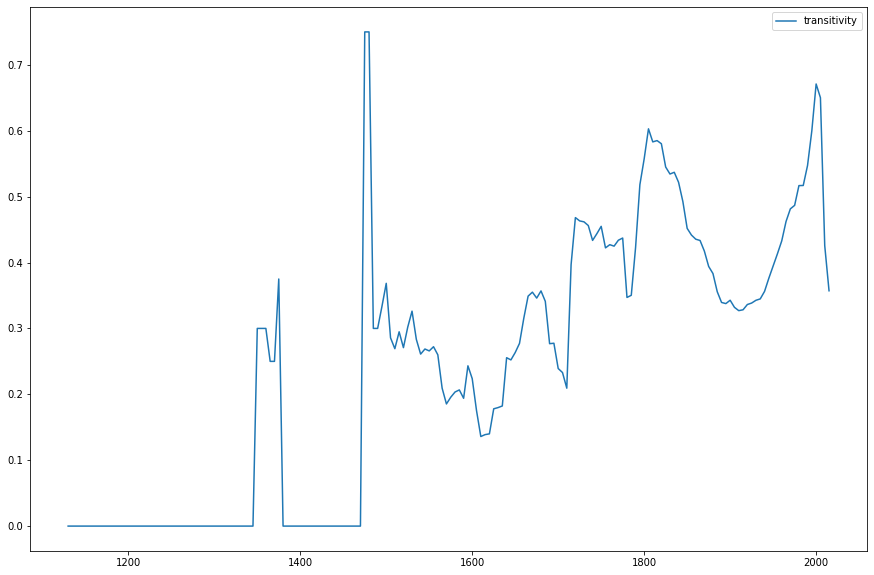

In [38]:
plt.rcParams['figure.figsize'] = [15, 10]

plt.plot(annee_data['annee'], annee_data['transitivity'], label = 'transitivity')
plt.legend()
plt.show()

Mesure de clusterisation (moyenne des coefficients locaux de clusterisation)

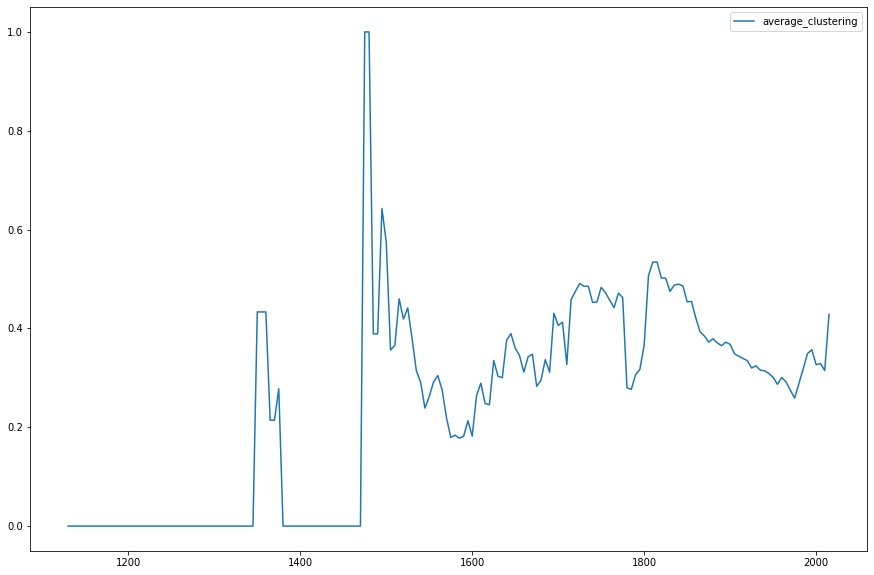

In [39]:
plt.rcParams['figure.figsize'] = [15, 10]

plt.plot(annee_data['annee'], annee_data['average_clustering'], label = 'average_clustering')
plt.legend()
plt.show()

Mesure du nombre de communautés détectées par l'algorithme de Louvain

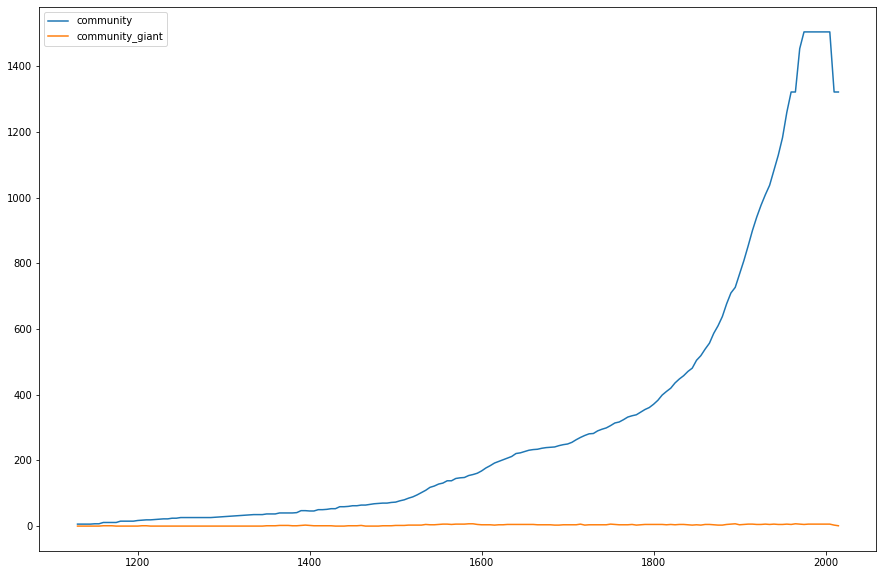

In [40]:
plt.rcParams['figure.figsize'] = [15, 10]

plt.plot(annee_data['annee'], annee_data['community'], label = 'community')
plt.plot(annee_data['annee'], annee_data['community_giant'], label = 'community_giant')
plt.legend()
plt.show()

Mesures de variance et de modularité

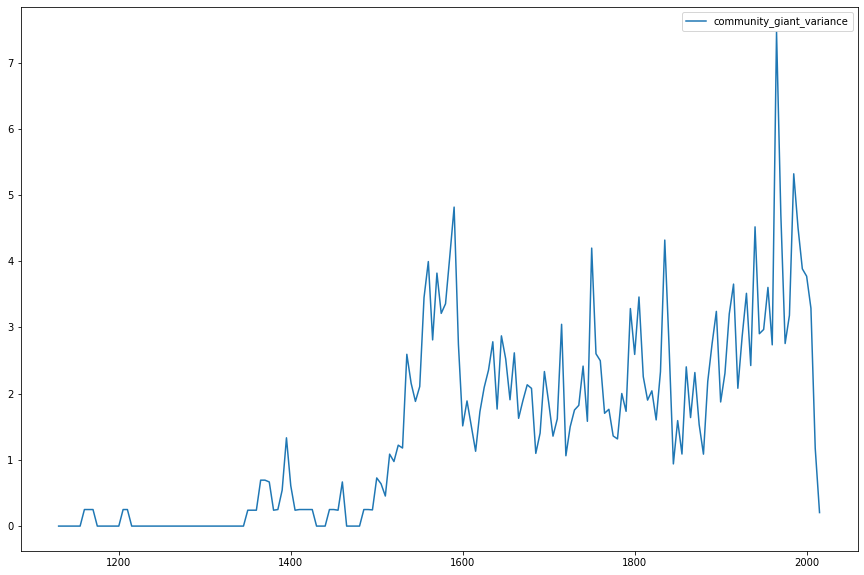

In [41]:
plt.rcParams['figure.figsize'] = [15, 10]

plt.plot(annee_data['annee'], annee_data['community_giant_variance'], label = 'community_giant_variance')
plt.legend()
plt.show()

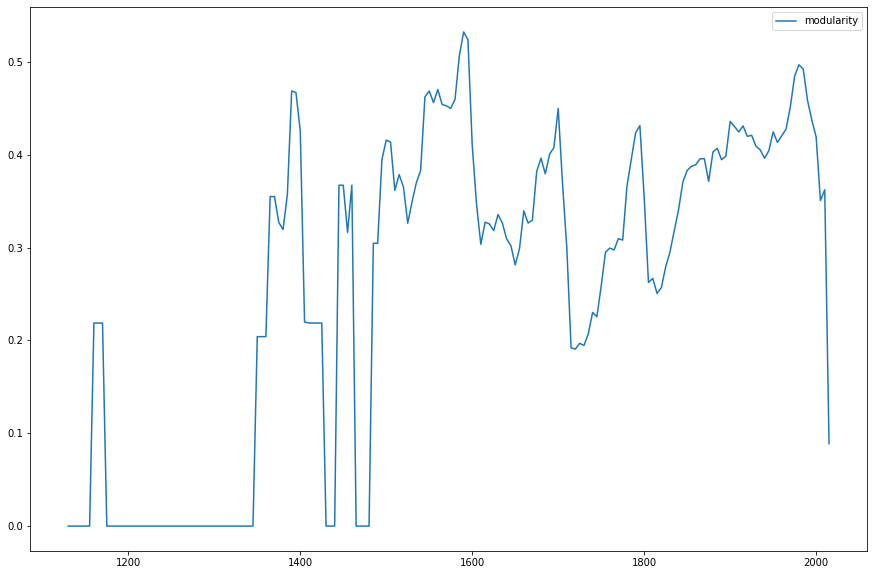

In [42]:
plt.rcParams['figure.figsize'] = [15, 10]

plt.plot(annee_data['annee'], annee_data['modularity'], label = 'modularity')
plt.legend()
plt.show()

### Comparaison d'émergence des genres et des métriques

On fait l'usage d'une densité plutôt que des valeurs entières pour caractériser l'émergence des genres. Cela nous permet de nous situer dans un espace continu.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.025 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


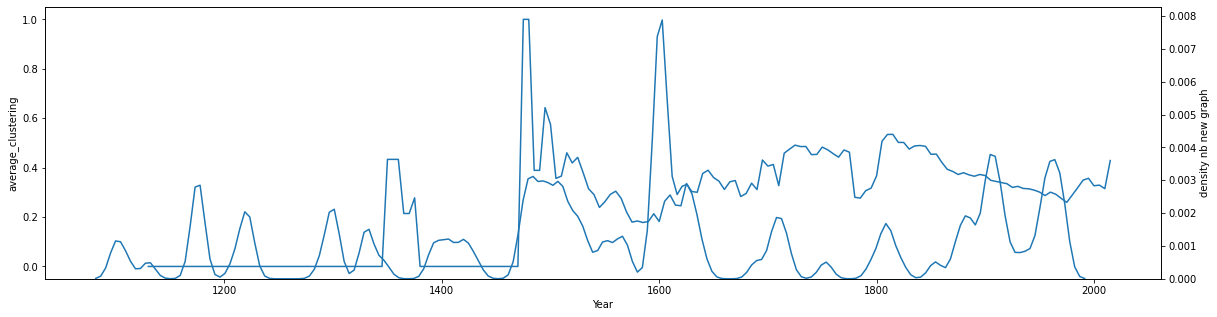

In [43]:
plt.rcParams['figure.figsize'] = [20, 5]
df_genre = df[df['type'] == 'genre']
df_genre = df_genre[df_genre['debut_genre'] != 9999]
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(annee_data['annee'], annee_data['average_clustering'], label = 'average_clustering')
sns.kdeplot(df_genre['debut_genre'], bw=0.025, ax = ax2)
ax1.set_xlabel('Year')
ax1.set_ylabel('average_clustering')
ax2.set_ylabel('density nb new graph')
plt.show()



## Réseau pondéré

L'année dite de début d'un genre est très sensible aux légères variabilités (théorie des valeurs extrêmes) : un genre mentionné par simple hasard sur la page d'un auteur du sièce précédent fait décaler toute la valeur d'un siècle. Pour désigner l'année de début, on réalise une moyenne des 2e et 3e années d'apparition minimales.  Exclure la première permet d'éviter le problème des valeurs extrêmes et moyenniser permet de lisser la date d'émergence du genre. C'est un choix arbitraire, mais que l'on suppose valable.

In [44]:
df['debut_genre_moyenne3'] = None
for genre in df[df['type'] == 'genre'].index :
  subset = df[df['genres_mentionnes'].apply(str).str.contains(str(genre)).tolist()]
  annees = np.unique(subset.date_naissance)
  annees = [x for x in annees if str(x) != 'nan']
  annees = np.sort(annees)[1:3]
  if len(annees) >= 2 :
    df.loc[genre, 'debut_genre_moyenne3'] = np.average(annees)

On visualise la différence entre la densité d'émergence des genres avec ou sans la pondération contrôlant pour l'éclatement des genres.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.025 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.025 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


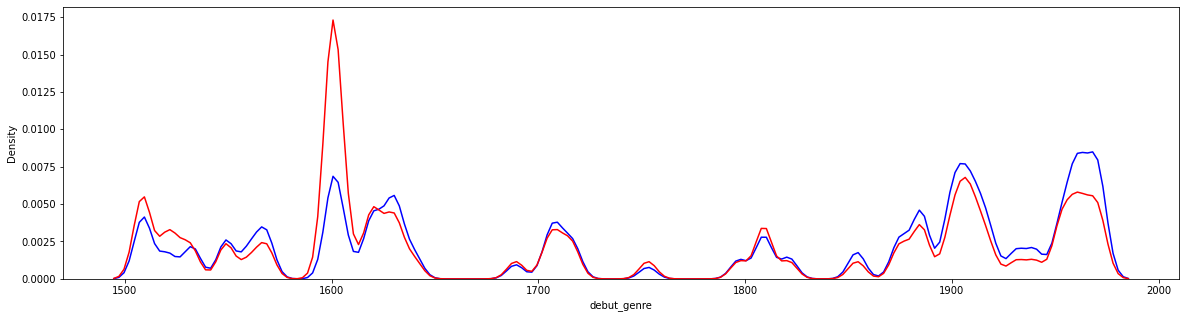

In [45]:
df_genre = df[df['type'] == 'genre']
date_debut = 1500 
date_fin = 2050
BOOL_genre = (df_genre['debut_genre'] > date_debut) & (df_genre['debut_genre'] < date_fin)

sns.kdeplot('debut_genre', bw=0.025, weights= 'poids_genre', label = 'Nb nouveau genre par année', color = 'blue', data = df_genre[BOOL_genre])
sns.kdeplot('debut_genre', bw=0.025, color = 'red', data = df_genre[BOOL_genre])

On visualise la différence entre la densité d'émergence des genres avec ou sans la pondération contrôlant pour l'éclatement des genres  et avec le lissage sur la date d'émergence.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.025 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.025 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.025 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


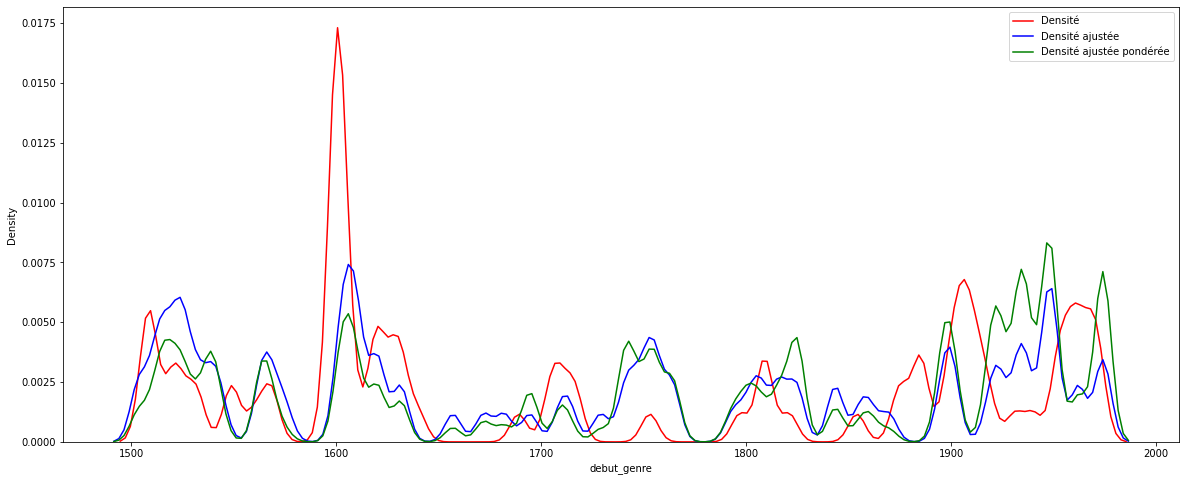

In [67]:
plt.rcParams['figure.figsize'] = [20, 8]

date_debut = 1500 
date_fin = 2050 
BOOL_genre1 = (df_genre['debut_genre'] > date_debut) & (df_genre['debut_genre'] < date_fin)
BOOL_genre2 = (df_genre['debut_genre_moyenne3'] > date_debut) & (df_genre['debut_genre_moyenne3'] < date_fin)

sns.kdeplot('debut_genre', bw=0.025, label = 'Densité', color = 'red', data = df_genre[BOOL_genre1])
sns.kdeplot('debut_genre_moyenne3', bw=0.025, label = 'Densité ajustée', color = 'blue', data = df_genre[BOOL_genre2])
sns.kdeplot('debut_genre_moyenne3', bw=0.025, weights= 'poids_genre', label = 'Densité ajustée pondérée', color = 'green', data = df_genre[BOOL_genre2])

plt.legend()



In [50]:
# Year subsets and building metrics
df_auteurs = df
measure_list = {}
for année in tqdm_notebook(reversed(range(1000, 2025, 5))) :
  selected_nodes = [node for node, value in GraphAuthorLink.nodes(data=True) if (value['date_mort'] >= année) & (value['date_naissance'] <= année)] 
  subgraph = GraphAuthorLink.subgraph(selected_nodes)
  # if len(selected_nodes) > 10 :
  if len(selected_nodes) > 1 :
    try :
      volume_annuel = nx.get_node_attributes(subgraph, 'taille_html_article')
      subgraph_undirected = subgraph.to_undirected()
      subgraph_undirected_connected_components = sorted(nx.connected_components(subgraph_undirected), key=len, reverse=True)
      subgraph_undirected_giant = subgraph_undirected.subgraph(subgraph_undirected_connected_components[0])
      total_articles_len = 0
      community_giant = community_louvain.best_partition(subgraph_undirected_giant, randomize = False)
      for key in subgraph.nodes() :
        total_articles_len += np.log(nx.get_node_attributes(subgraph, 'taille_html_article')[key])
      measure_list[année] = {'average_clustering' : nx.average_clustering(subgraph),
                             'average_clustering_weight' : nx.average_clustering(subgraph, weight = 'weight'),
                             'average_clustering_weight2' : nx.average_clustering(subgraph, weight = 'weight2'),
                             'total_articles_len' : total_articles_len,
                             'modularity' : community_louvain.modularity(community_giant, subgraph_undirected_giant, weight = None),
                             'modularity_weight' : community_louvain.modularity(community_giant, subgraph_undirected_giant, weight = 'weight'),
                             'modularity_weight2' : community_louvain.modularity(community_giant, subgraph_undirected_giant, weight = 'weight2')}
    except : 
      pass

annee_data = pd.DataFrame(measure_list).T
annee_data['annee'] = annee_data.index

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.025 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


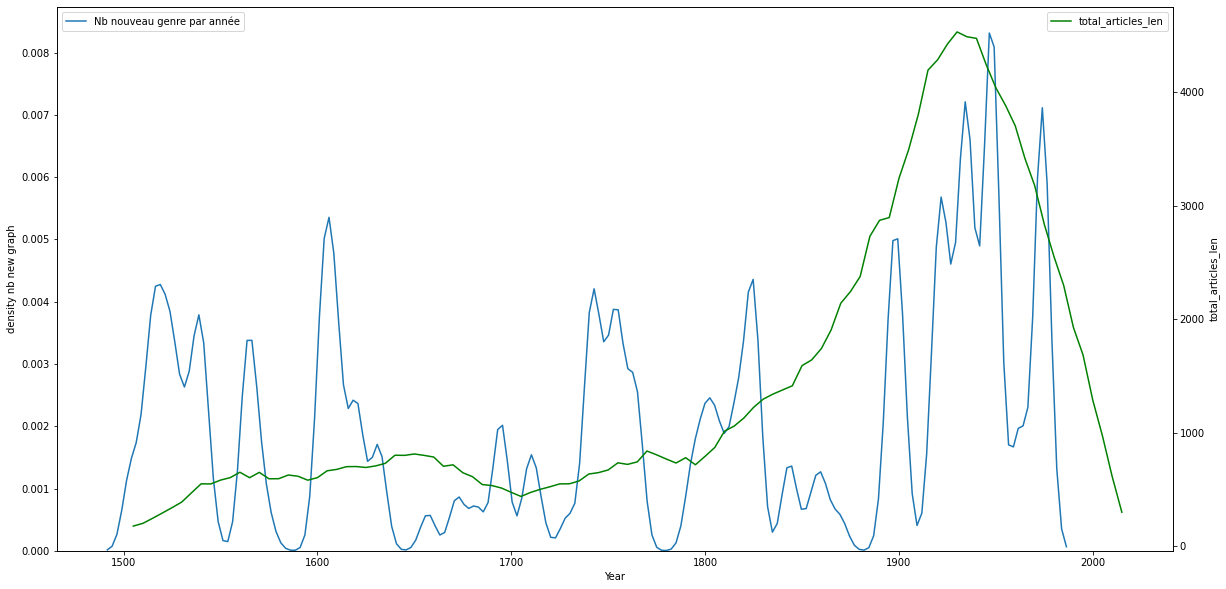

In [51]:
plt.rcParams['figure.figsize'] = [20, 10]

date_debut = 1500 
date_fin = 2050 
BOOL_genre = (df_genre['debut_genre_moyenne3'] > date_debut) & (df_genre['debut_genre_moyenne3'] < date_fin)
BOOL_data = (annee_data['annee'] > date_debut) & (annee_data['annee'] < date_fin)

fig, ax1 = plt.subplots()

sns.kdeplot('debut_genre_moyenne3', bw=0.025, weights= 'poids_genre', label = 'Nb nouveau genre par année', data = df_genre[BOOL_genre])
ax1.set_xlabel('Year')
ax1.set_ylabel('density nb new graph')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
plt.plot(annee_data['annee'][BOOL_data], annee_data['total_articles_len'][BOOL_data], label = 'total_articles_len', color = 'g')

plt.legend()
ax2.set_ylabel('total_articles_len')

plt.show()

### Métriques (avec pondération)

#### Visualisation des corrélation entre émergence des genres et structures de réseau

Taille des articles

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.025 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


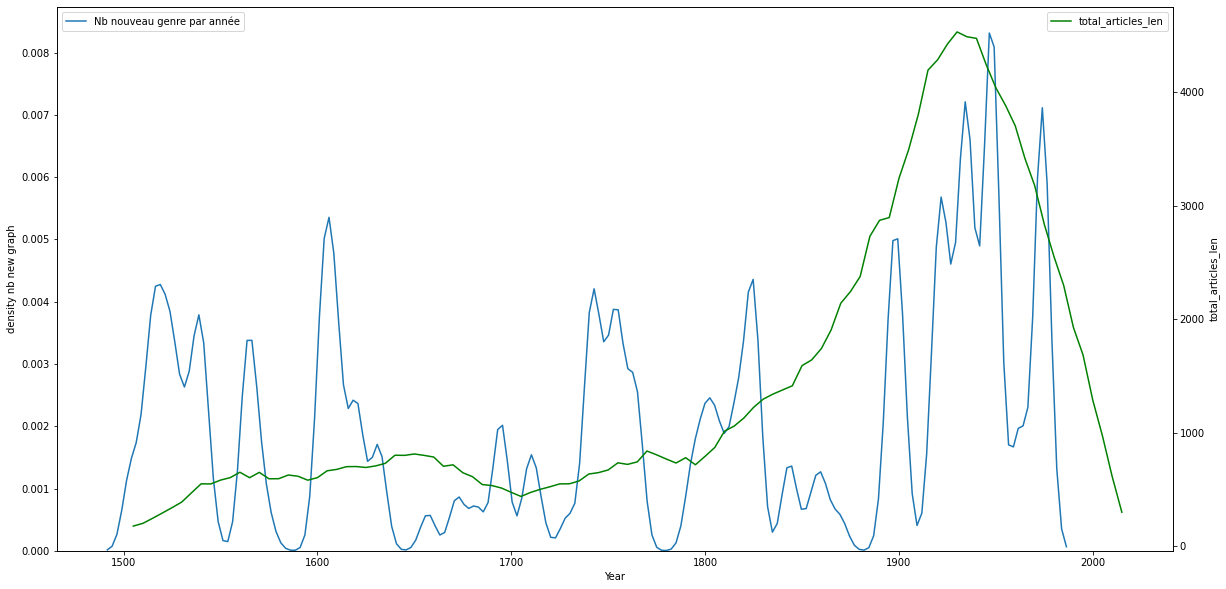

In [52]:
plt.rcParams['figure.figsize'] = [20, 10]

date_debut = 1500 
date_fin = 2050 
BOOL_genre = (df_genre['debut_genre_moyenne3'] > date_debut) & (df_genre['debut_genre_moyenne3'] < date_fin)
BOOL_data = (annee_data['annee'] > date_debut) & (annee_data['annee'] < date_fin)

fig, ax1 = plt.subplots()

sns.kdeplot('debut_genre_moyenne3', bw=0.025, weights= 'poids_genre', label = 'Nb nouveau genre par année', data = df_genre[BOOL_genre])
ax1.set_xlabel('Year')
ax1.set_ylabel('density nb new graph')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
plt.plot(annee_data['annee'][BOOL_data], annee_data['total_articles_len'][BOOL_data], label = 'total_articles_len', color = 'g')

plt.legend()
ax2.set_ylabel('total_articles_len')

plt.show()

Clusterisation : moyenne des coeff. locaux de clusterisation

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.025 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


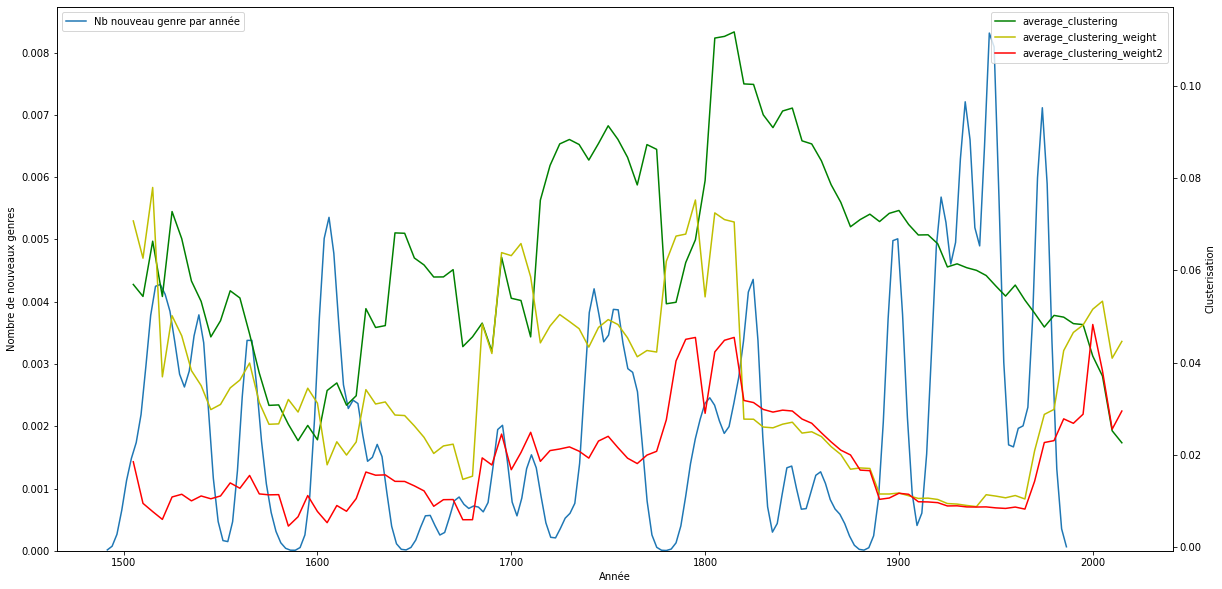

In [53]:
plt.rcParams['figure.figsize'] = [20, 10]

date_debut = 1500 
date_fin = 2050 
BOOL_genre = (df_genre['debut_genre_moyenne3'] > date_debut) & (df_genre['debut_genre_moyenne3'] < date_fin)
BOOL_data = (annee_data['annee'] > date_debut) & (annee_data['annee'] < date_fin)

fig, ax1 = plt.subplots()

sns.kdeplot('debut_genre_moyenne3', bw=0.025, weights= 'poids_genre', label = 'Nb nouveau genre par année', data = df_genre[BOOL_genre])
ax1.set_xlabel('Année')
ax1.set_ylabel('Nombre de nouveaux genres')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
plt.plot(annee_data['annee'][BOOL_data], annee_data['average_clustering'][BOOL_data]*0.25, label = 'average_clustering', color = 'g')
plt.plot(annee_data['annee'][BOOL_data], annee_data['average_clustering_weight'][BOOL_data], label = 'average_clustering_weight', color = 'y')
plt.plot(annee_data['annee'][BOOL_data], annee_data['average_clustering_weight2'][BOOL_data], label = 'average_clustering_weight2', color = 'r')

plt.legend()
ax2.set_ylabel('Clusterisation')

plt.show()



Modularité

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.025 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


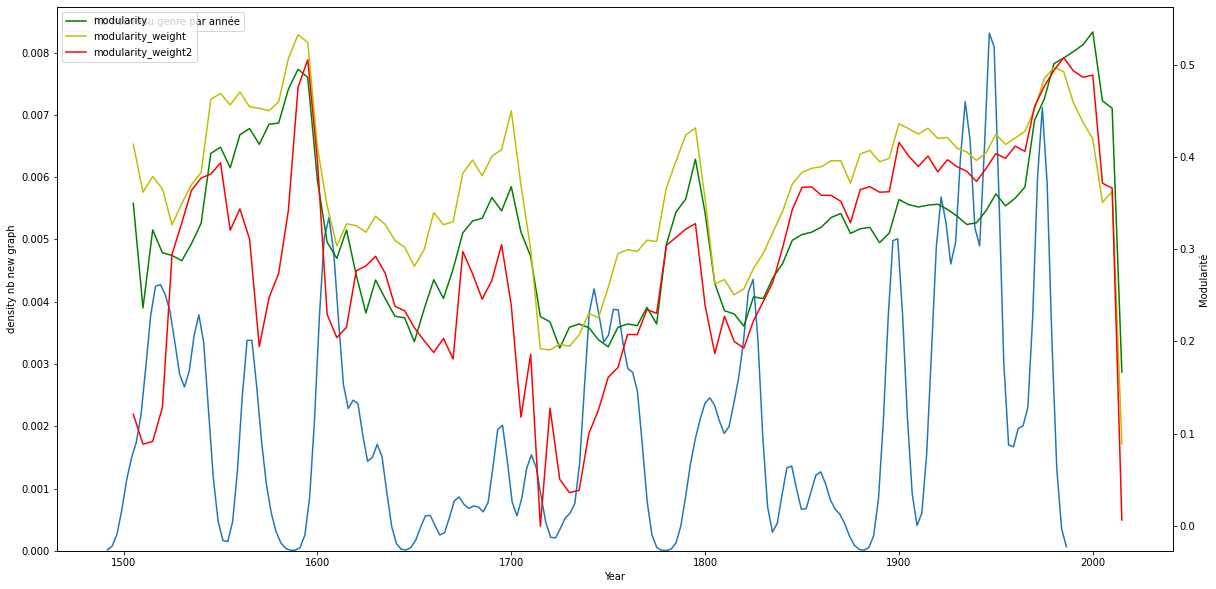

In [54]:
plt.rcParams['figure.figsize'] = [20, 10]

date_debut = 1500 
date_fin = 2050 
BOOL_genre = (df_genre['debut_genre_moyenne3'] > date_debut) & (df_genre['debut_genre_moyenne3'] < date_fin)
BOOL_data = (annee_data['annee'] > date_debut) & (annee_data['annee'] < date_fin)

fig, ax1 = plt.subplots()

sns.kdeplot('debut_genre_moyenne3', bw=0.025, weights= 'poids_genre', label = 'Nb nouveau genre par année', data = df_genre[BOOL_genre])
ax1.set_xlabel('Year')
ax1.set_ylabel('density nb new graph')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
plt.plot(annee_data['annee'][BOOL_data], annee_data['modularity'][BOOL_data], label = 'modularity', color = 'g')
plt.plot(annee_data['annee'][BOOL_data], annee_data['modularity_weight'][BOOL_data], label = 'modularity_weight', color = 'y')
plt.plot(annee_data['annee'][BOOL_data], annee_data['modularity_weight2'][BOOL_data], label = 'modularity_weight2', color = 'r')

plt.legend()
ax2.set_ylabel('Modularité')

plt.show()



### Régressions

Le but de cette dernière partie est de rendre compte des coorélations entre structures de réseaux et émergence de genres analytiquement. Visuellement, il est difficile de se prononcer sur l'existence de corrélation dans quelque sens que ce soit. Nous adoptons le modèle de régression linéaire aux moindres carrés ordinaires avec comme variable dépendante le nombre de nouveaux genres.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1699: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.025 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


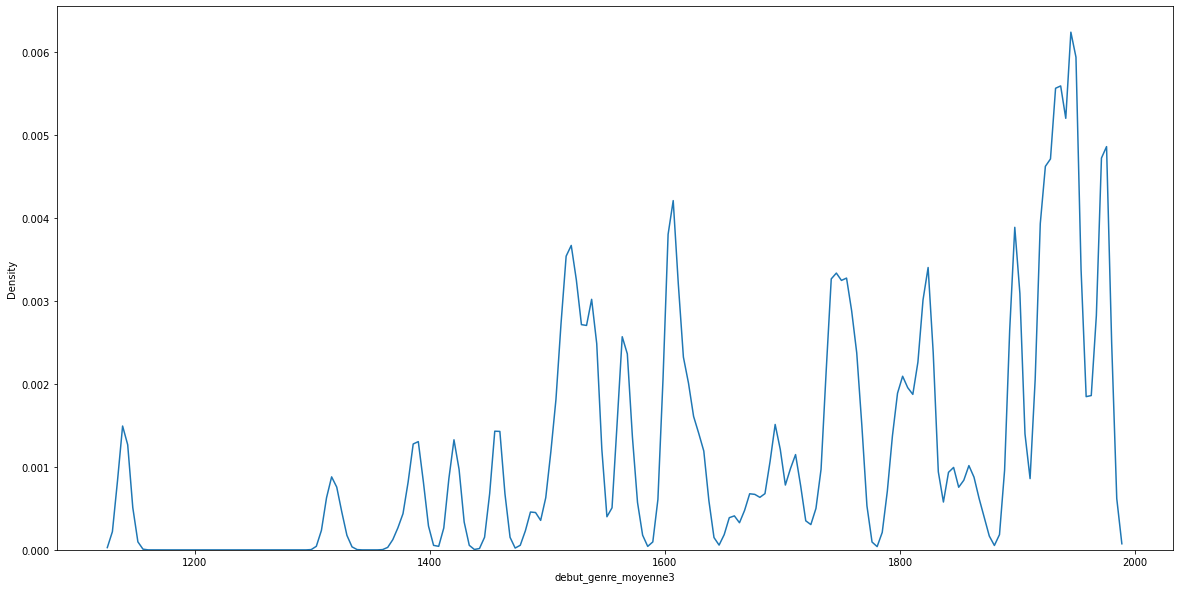

In [55]:
date_debut = 1100 
date_fin = 2100 
BOOL_genre = (df_genre['debut_genre_moyenne3'] > date_debut) & (df_genre['debut_genre_moyenne3'] < date_fin)

plot = sns.kdeplot('debut_genre_moyenne3', bw=0.025, weights= 'poids_genre', label = 'Nb nouveau genre par année', data = df_genre[BOOL_genre])

annee_mean_liste = list(plot.get_lines()[0].get_data()[1])
annees = list(plot.get_lines()[0].get_data()[0])
annees = [int(annee) for annee in annees]
annee_mean_df = pd.DataFrame({'annee' : annees, 'annee_mean' : annee_mean_liste})
annee_mean_df = pd.merge(pd.DataFrame({'annee' : range(date_debut, date_fin)}), annee_mean_df, on = 'annee', how = 'outer')
annee_mean_df['annee_mean'][-1:] = 0
annee_mean_df['annee_mean_interpolated' ] = annee_mean_df.annee_mean.interpolate(method = 'polynomial', order = 2, limit_direction = 'both')

regression_data = pd.merge(annee_data, annee_mean_df, on = 'annee', how = 'inner')

In [56]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
import statsmodels.formula.api as smf

def regression(periode, var_dependante, vars_explicatives, vars_controle, data_reg, lag_explicatives = 0, annee_correction = 0) :

  regression_subset = data_reg.copy()

  regression_subset[var_dependante] = 1000*regression_subset[var_dependante]

  regression_subset[var_dependante] = regression_subset[var_dependante].shift(int(annee_correction/5))
  regression_subset[vars_controle] = regression_subset[vars_controle].shift(int(annee_correction/5))

  date_debut = periode[0] 
  date_fin = periode[1] 
  BOOL_regression = (regression_subset['annee'] > date_debut) & (regression_subset['annee'] < date_fin)
  regression_subset = regression_subset[BOOL_regression]

  for var in vars_explicatives :
    regression_subset[var] = regression_subset[var].shift(-int(lag_explicatives/5))

  regression_subset = regression_subset[[var_dependante] + vars_explicatives + vars_controle]
  regression_subset = regression_subset.dropna()

  expression = var_dependante + ' ~ ' + ' + '.join(vars_explicatives) + ' + ' + ' + '.join(vars_controle)
  model = smf.ols(expression, data = regression_subset).fit()
  summary = model.summary()
  params = '\n'.join(['periode' + ' :  ' + str(periode), 
                     'var_dependante' + ' :  ' + str(var_dependante), 
                     'vars_explicatives' + ' :  ' + str(vars_explicatives), 
                     'vars_controle' + ' :  ' + str(vars_controle), 
                     'lag_explicatives' + ' :  ' + str(lag_explicatives),
                     'annee_correction' + ' : ' + str(annee_correction)])
  
  return(summary, params, regression_subset)


In [57]:
reg, params, reg_data = regression(periode = [1500, 1990],
                          var_dependante = 'annee_mean_interpolated',
                          vars_explicatives = ['modularity_weight2'],
                          vars_controle = ['total_articles_len', 'annee'],
                          lag_explicatives = 50,
                          annee_correction = 30, 
                          data_reg = regression_data)
print(params)
print(reg)
print('\n\n\n888888888888888888888888888888888888888888888888888888888888888888888888888888888888\n\n\n')


periode :  [1500, 1990]
var_dependante :  annee_mean_interpolated
vars_explicatives :  ['modularity_weight2']
vars_controle :  ['total_articles_len', 'annee']
lag_explicatives :  50
annee_correction : 30
                               OLS Regression Results                              
Dep. Variable:     annee_mean_interpolated   R-squared:                       0.332
Model:                                 OLS   Adj. R-squared:                  0.308
Method:                      Least Squares   F-statistic:                     13.76
Date:                     Fri, 29 Apr 2022   Prob (F-statistic):           2.29e-07
Time:                             17:50:58   Log-Likelihood:                -142.97
No. Observations:                       87   AIC:                             293.9
Df Residuals:                           83   BIC:                             303.8
Df Model:                                3                                         
Covariance Type:                 nonrobu